## Integrating a simple harmonic oscillator and trying to infer the spring constant

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.optimize as so
%matplotlib inline
import autograd.numpy as np # Thinly-wrapped numpy
#import numpy as np  
from autograd import grad  
import tensorflow as tf
from tensorflow.contrib import autograph
import leapfrog as lf
from tensorflow.python.ops import gradients_impl

In [3]:
tf.VERSION

'1.10.0'

##  Define python functions first to compare with TF to debug 

In [14]:
def genData(x, v, npoints, std_noise_x, std_noise_v):
    noise_x = np.random.normal(0, std_noise_x, len(x))
    noise_v = np.random.normal(0, std_noise_v, len(x))
    return noise_x + x, noise_v + v

def ln_likelihood(theta, data, dt_model):
    chi2 = 0
    k, x0, v0, *t_obs = theta
    x_obs, v_obs, sigma_x, sigma_v = data
    x, v, _, _ = leapfrog(x0, v0, np.array(t_obs), potential_and_grad_py, dt_model, k=k)
    chi2 += -(v - v_obs)**2 / sigma_v**2 - 2*np.log(sigma_v)
    chi2 += -(x - x_obs)**2 / sigma_x**2 - 2*np.log(sigma_x)
    return 0.5*chi2.sum()

def tf_log_like(x0, v0, k, t_obs, step_size, data, name='loglikelihood'):
    with tf.name_scope(name):
        chi2 = 0
        x_obs, v_obs, sigma_x, sigma_v = data
        x, v = lf.leapfrog(x0, v0, k, t_obs, step_size, name='leapfrog')
        chi2 += -(v - v_obs)**2 / sigma_v**2 - 2*np.log(sigma_v)
        chi2 += -(x - x_obs)**2 / sigma_x**2 - 2*np.log(sigma_x)
        return 0.5*tf.reduce_sum(chi2)

def nll_python(*args):
    return -ln_likelihood(*args)

def potential_and_grad_py(position, k=1.0):
    #function that returns the potential and it's gradient at a given position
    return 0.5 * k * position**2, k*position

def leap(position, momentum, grad, potential_and_grad, step_size, k=1.0):
    momentum -= 0.5 * step_size * grad
    position += step_size * momentum
    potential, grad = potential_and_grad_py(position, k=k)
    momentum -= 0.5 * step_size * grad
    return position, momentum, potential, grad

def leapfrog(x0, v0, t_obs, potential_and_grad_py, dt, k=np.float64(1.0)):
    #function that takes initial conditions that takes us to the next position 
    x = [] 
    v = [] 
    t = [] 
    grads = []
    time = []
    
    tprime = 0.0
    xprime = x0
    vprime = v0

    pot, grad = potential_and_grad_py(xprime, k=k)
    for to in t_obs:

        while tprime + dt < to:
            xprime, vprime, pot, grad = leap(xprime, vprime, grad, potential_and_grad_py, dt, k=k)
            tprime = tprime + dt    
        dt_tiny = to - tprime
        xsave, vsave, potsave, gradsave = leap(xprime, vprime, grad, potential_and_grad_py, dt_tiny, k=k)
        tsave = tprime + dt_tiny
        #print(xsave, vsave, tsave, potsave, gradsave)
        x.append(xsave)
        v.append(vsave)
        t.append(tsave)
        grads.append(grad)
        time.append(tprime)
        #print(x, v)
    return np.array(x), np.array(v), np.array(grads), np.array(time) #, np.array(t)

def finite_difference_grads(k_true, x0_true, 
                            v0_true, t_obs_true, 
                            epsilon):
    grads = []
    
    k = k_true
    x0 = x0_true
    v0 = v0_true
    t0 = t_obs_true
    k = k_true + epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    kp = nll_python(p0_test, data, s_size)
    k = k_true - epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    km = nll_python(p0_test, data, s_size)
    k = k_true

    grads.append((kp - km)/epsilon)


    x0 = x0_true + epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    xp = nll_python(p0_test, data, s_size)
    x0 = x0_true - epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    xm = nll_python(p0_test, data, s_size)
    x0 = x0_true

    grads.append((xp - xm)/epsilon)

    v0 = v0_true + epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    vp = nll_python(p0_test, data, s_size)
    v0 = v0_true - epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    vm = nll_python(p0_test, data, s_size)
    v0 = v0_true

    grads.append((vp - vm)/epsilon)

    for i, t in enumerate(t0):
        t_obs_true[i] = t + epsilon/2.
        p0_test = [k, x0, v0] + (t0).tolist()
        tp = nll_python(p0_test, data, s_size)
        t_obs_true[i] = t - epsilon/2.
        p0_test = [k, x0, v0] + (t0).tolist()
        tm = nll_python(p0_test, data, s_size)
        t_obs_true[i] = t

        grads.append((tp - tm)/epsilon)
    return grads

In [15]:
np.random.seed(1)

## Set some true values and initial guesses

In [16]:
#define true parameter values we will add noise to later
x0_true   = np.float64(10.)
v0_true   = np.float64(10.)
k_true    = np.float64(3.)

#define step size of each leap and number of shos
s_size = np.float64(0.01)      #resolution of each leap
n_shos = 1            #number of simple harmonic oscillators 

#define true observed times
max_time  = np.float64(10.)
nobspoints = 10
t_obs_true = np.random.uniform(0, max_time, nobspoints)
t_obs_true.sort()

#define noise properties 
std_noise_x = 1.0
std_noise_v = 1.0

## Generate fake data and model predictions using python implementation (which I trust)

In [17]:
#generate true values and noisify them
x_true, v_true, grad_true, time_steps_true = leapfrog(x0_true, v0_true, t_obs_true, potential_and_grad_py, s_size, k=k_true)
x_obs, v_obs = genData(x_true, v_true, nobspoints, std_noise_x, std_noise_v)

In [18]:
data   = [x_obs, v_obs, std_noise_x, std_noise_v]

k_guess = k_true  + np.random.normal(0, k_true)
x0_guess = x0_true + np.random.normal(0, std_noise_x)
v0_guess = v0_true + np.random.normal(0, std_noise_v)
t0_guess = t_obs_true #+ np.random.normal(0, 1., len(t_obs_true))
t0_guess.sort()
p0_guess = [k_guess, 
          x0_guess, 
          v0_guess] + (t0_guess).tolist()

#for plotting purposes
t_compare = np.linspace(0, max_time, 1000)

## Calculate log likelihood of python model

In [19]:
#calculate log likelihood of initial guesses using python leapfrog model
theta = [k_guess, x0_guess, v0_guess] + t0_guess.tolist()
data = [x_obs, v_obs, std_noise_x, std_noise_v]
python_loglikelihood = ln_likelihood(theta, data, s_size)

## Calculate autograd gradients

In [20]:
#define autograd gradient function
grad_ln_like = grad(nll_python)

In [21]:
grads_autograd = grad_ln_like(p0_guess, data, s_size)

## Calculate finite difference gradients

In [22]:
epsilon = 0.0001
grads_finite_difference = finite_difference_grads(k_guess, x0_guess, v0_guess, t0_guess, epsilon)

## Now try with TensorFlow
## Define Tensorflow variables and Tensorflow models

In [28]:
#define log likelihood model
#ll = tf_log_like(x, v, x_obs_tf, v_obs_tf, std_noise_x_tf, std_noise_v_tf)
tf.reset_default_graph()

data = [x_obs, v_obs, std_noise_x, std_noise_v]

#turn initial parameter guesses into tensorflow tensors so tensorflow can take gradients of them

x0_tf    = tf.Variable(tf.constant(x0_guess), name = "x0"   , dtype=np.float64)
v0_tf    = tf.Variable(tf.constant(v0_guess), name = "v0"   , dtype=np.float64)
k_tf     = tf.Variable(tf.constant(k_guess),  name = "k"    , dtype=np.float64)
t_obs_tf = tf.Variable(tf.constant(t0_guess), name = "t_obs", dtype=np.float64)    

#define tensorflow models
#returns the modeled x and v values 
model = lf.leapfrog(x0_tf, v0_tf, k_tf, t_obs_tf, s_size, name='leapfrog')
#returns the negative log likelihood of the parameters
nll = -tf_log_like(x0_tf, v0_tf, k_tf, t_obs_tf, s_size, data, name='negativeloglike')
#returns the likelihood of the parameters
ll = tf_log_like(x0_tf, v0_tf, k_tf, t_obs_tf, s_size, data, name='loglikelihood')

#returns the gradients of the negative log likelihood
gradients = gradients_impl.gradients(nll, [k_tf, x0_tf, v0_tf, t_obs_tf]) #, current_v, k])


## Run the Tensorflow models 

In [14]:
session = tf.Session()
#initialize all variables that are defined
session.run(tf.global_variables_initializer())
#run model to get x, v for debugging purposes in plots below
x, v = session.run(model)
writer = tf.summary.FileWriter("/tmp/leapfrog/model")
writer.add_graph(session.graph)
#compute likelihood of model parameters
tensorflow_loglikelihood = session.run(ll)
writer = tf.summary.FileWriter("/tmp/leapfrog/loglike")
writer.add_graph(session.graph)
#compute the gradients of the negative log likelihood with respect to all the parameters 
grads_tensorflow = session.run(gradients)
writer = tf.summary.FileWriter("/tmp/leapfrog/negloglike")
writer.add_graph(session.graph)


## Now plot some stuff

In [15]:
#generate values using python leapfrog from initial guesses to plot
plot_t_obs_values = np.linspace(0, max_time, 1000)
xleap_plot, vleap_plot, gradleap_plot, timeleap_plot = leapfrog(x0_guess,
                                            v0_guess,
                                            plot_t_obs_values,
                                            potential_and_grad_py,
                                            s_size,
                                            k=k_guess)

In [16]:
#generate values using python leapfrog from initial guesses to compare with tf model
xleap, vleap, gradleap, timeleap = leapfrog(x0_guess,
                                            v0_guess,
                                            t0_guess,
                                            potential_and_grad_py,
                                            s_size,
                                            k=k_guess)

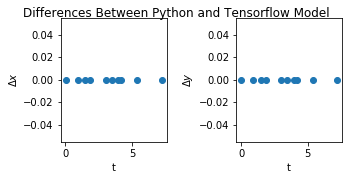

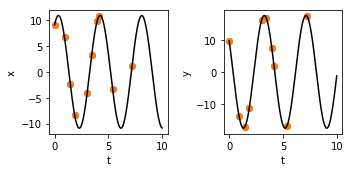

In [17]:

#now plot some stuff
fig, ax = plt.subplots(1,2, figsize=(5, 2.5))
ax[0].plot(t0_guess, x - xleap, 'o')
#print(session.run(x))
ax[0].set_xlabel('t')
ax[0].set_ylabel('$\Delta x$')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$\Delta y$')
ax[1].plot(t0_guess, v - vleap, 'o')
fig.suptitle('Differences Between Python and Tensorflow Model')
plt.tight_layout()

fig, ax = plt.subplots(1,2, figsize=(5, 2.5))
ax[0].plot(t0_guess, xleap, 'o', label='python')
ax[0].plot(t0_guess, x, 'o', label='tf')
ax[0].plot(plot_t_obs_values, xleap_plot, 'k-')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].plot(t0_guess, vleap, 'o')
ax[1].plot(t0_guess, v, 'o')
ax[1].plot(plot_t_obs_values, vleap_plot, 'k-')
plt.legend()
plt.tight_layout()

## Print the gradients to show Tensorflow, Autograd, and Finite Differences generate the same values

In [18]:
print('Python loglikelihood is: {0}'.format(python_loglikelihood))
print('Tensorflow loglikelihood is: {0}'.format(tensorflow_loglikelihood))

Python loglikelihood is: -206.48631941943643
Tensorflow loglikelihood is: -206.48631941943646


In [19]:
keys = ['k', 'x0', 'v0'] + ['tobs']*nobspoints
print('Gradients of Negative Log Likelihood')
print('  TensorFlow  Autograd  FiniteDifference ')
for tg, ag, fg, k in zip(grads_tensorflow[0:3], grads_autograd[0:3], grads_finite_difference[0:3], keys[0:3]):
    print('{0}  {1:0.3f}   {2:0.3f}   {3:0.3f}'.format(k, tg, ag, fg))

Gradients of Negative Log Likelihood
  TensorFlow  Autograd  FiniteDifference 
k  -910.590   -910.590   -910.590
x0  -23.758   -23.758   -23.758
v0  40.665   40.665   40.665


In [20]:
print('Gradients of Negative Log Likelihood')
print('  TensorFlow  Autograd  FiniteDifference ')
for tg, ag, fg, k in zip(grads_tensorflow[3].values[::-1][:-1], grads_autograd[3:], grads_finite_difference[3:], keys[3:]):
    print('{0}   {1:0.3f}    {2:0.3f}    {3:0.3f}'.format(k, tg, ag, fg))

Gradients of Negative Log Likelihood
  TensorFlow  Autograd  FiniteDifference 
tobs   -23.906    -23.906    -23.906
tobs   -105.840    -105.840    -105.840
tobs   -33.586    -33.586    -33.586
tobs   -104.049    -104.049    -104.049
tobs   -120.278    -120.278    -120.278
tobs   -50.893    -50.893    -50.893
tobs   -212.029    -212.029    -212.029
tobs   -266.304    -266.304    -266.304
tobs   -137.818    -137.818    -137.818
tobs   -146.409    -146.409    -146.409


In [21]:
# First we say that we want the model to return the value and gradient
# of `log_prob` as a function of the parameters 

from helpers import TFModel
model = TFModel(ll, [k_tf, x0_tf, v0_tf])

# Within the session, you first need to call the `setup` method.
model.setup(session)

# You can access the current parameter vector for the model.
# This will always be a flat numpy array.
params = model.current_vector()
print(params)
# The value and gradient of the tensor can be evaluated for specific
# values of the parameters.
print("The value is: {0}".format(model.value(params)))
print("The gradient is: {0}".format(model.gradient(params)))


[2.63132932 9.06423057 9.73211192]
The value is: -206.48631941943646
The gradient is: [910.58954757  23.75812671 -40.66525166]


In [22]:
opt = tf.contrib.opt.ScipyOptimizerInterface(
    nll, var_list=[k_tf, x0_tf, v0_tf])


print("Initial parameters: {0}".format(session.run([k_tf, x0_tf, v0_tf])))
print("Initial log likelihood: {0}".format(session.run(ll)))
opt.minimize(session)

print("Final log likelihood: {0}\n".format(session.run(ll)))
params = session.run([k_tf, x0_tf, v0_tf])
print("Final parameters: {0}".format(params))
print("True parameters: {0} {1} {2}".format(k_true, x0_true, v0_true))

Initial parameters: [2.6313293234440556, 9.064230565740932, 9.732111920373985]
Initial log likelihood: -206.48631941943646
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 8.628458
  Number of iterations: 14
  Number of functions evaluations: 18
Final log likelihood: -8.628457685233188

Final parameters: [2.975277023636554, 9.933545619065734, 9.405778661050611]
True parameters: 3.0 10.0 10.0


In [23]:
writer = tf.summary.FileWriter("/tmp/leapfrog/1")
writer.add_graph(session.graph)

In [24]:
import time
import emcee

emcee_time = time.time()

model.setup(session)

pos = model.current_vector()
pos = pos + 1e-5*np.random.randn(8, len(pos))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, model.value)
pos, _, _ = sampler.run_mcmc(pos, 200)
sampler.reset()
pos, _, _ = sampler.run_mcmc(pos, 1000)
emcee_time = time.time() - emcee_time

emcee: Exception while calling your likelihood function:
  params: [ 2.95562224 10.1314648   9.18109745]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/landerson/ahw2018/shoderivz/helpers.py", line 380, in value
    return self.session.run(self.target, feed_dict=feed_dict)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 877, in run
    run_metadata_ptr)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1100, in _run
    feed_dict_tensor, options, run_metadata)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1272, in _do_run
    run_metadata)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1278, in _do_call
    return fn(*args)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1263, in _run_fn
    options, feed_dict, fetch_list, target_list, run_meta

KeyboardInterrupt: 

In [ ]:
plt.plot(sampler.chain[:, :, 1].T, alpha=0.3);

In [ ]:
import corner
true_params = [k_true, x0_true, v0_true]
truth = np.array(true_params)
# truth[-1] = np.log(true_params[-1])
corner.corner(sampler.flatchain,
              labels=["k", "x0", "v0"],
              truths=truth);


In [ ]:
np.var(sampler.flatchain, axis=0)

In [ ]:
import helpers

# We will cheat a little bit and use our previous chain to estimate the
# the appropriate tuning scales for the parameters.
metric = helpers.DiagonalMetric(3, np.var(sampler.flatchain, axis=0))
print(metric)

In [ ]:
metric.variance

In [ ]:
import helpers

# We will cheat a little bit and use our previous chain to estimate the
# the appropriate tuning scales for the parameters.
metric = helpers.DiagonalMetric(3, np.var(sampler.flatchain, axis=0)*10)

nuts_time = time.time()


# This method does the sampling:
nuts = helpers.tf_simple_nuts(
    session,
    ll,
    [k_tf, x0_tf, v0_tf],
    500,          # The number of MCMC steps
    0.1,           # The integration step size
    metric=metric  # The scaling metric computed above
)
nuts_time = time.time() - nuts_time


In [ ]:
corner.corner(nuts[0],
              range=[(np.min(v), np.max(v)) for v in sampler.flatchain.T],
              labels=["m", "b", "log(s)"],
              truths=truth);


In [ ]:
nuts[0]